# **Image Localization & Classification**

## Import Dependencies

In [1]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from xml.etree import ElementTree as et
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.applications import VGG16

tf.debugging.set_log_device_placement(False)

2024-08-21 05:27:01.282837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 05:27:01.282899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 05:27:01.284653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data loading and Visualization

In [2]:
images_dir = "/kaggle/input/localization-data/dataset/data"
annotations_dir = "/kaggle/input/localization-data/dataset/Annotations"

In [3]:
image_size = 224

In [4]:
os.listdir(images_dir)

['Fan', 'Ac', 'Stove', 'Refrigerator', 'Hair_Dryer']

In [5]:
os.listdir(annotations_dir)

['hair_dryer_annotations',
 'stove_annotations',
 'ac_annotations',
 'fan_annotations',
 'refrigerator_annotations']

In [6]:
def rescale_bbox(bbox, original_size=(600, 600), new_size=(224, 224)):
    original_width, original_height = original_size
    new_width, new_height = new_size
    
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    
    x_min, y_min, x_max, y_max = bbox
    
    new_x_min = int(x_min * x_scale)
    new_y_min = int(y_min * y_scale)
    new_x_max = int(x_max * x_scale)
    new_y_max = int(y_max * y_scale)
    
    return (new_x_min, new_y_min, new_x_max, new_y_max)

In [7]:
seed_value = 30
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

class_names = ['ac', 'fan', 'dryer', 'fridge', 'stove']

def get_value_dicts(files):
    data = {}

    for file_path in files:

        tree = et.parse(file_path)
        root = tree.getroot()

        file_name = root.find("filename").text
        path = root.find("path").text

        object_ = root.find("object")
        class_name = object_.find("name").text

        class_index = class_names.index(class_name)

        bndbox = object_.find("bndbox")

        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        
        xmin, ymin, xmax, ymax = rescale_bbox([xmin, ymin, xmax, ymax], new_size=(image_size, image_size))

        data[file_name] = [path, class_index, [xmin, ymin, xmax, ymax]]
                
    return data

In [8]:
annotations_list = [os.path.join(annotations_dir, dir_, filename) for dir_ in os.listdir(annotations_dir)
                    for filename in os.listdir(os.path.join(annotations_dir, dir_))]

random.shuffle(annotations_list)
data_dict = get_value_dicts(annotations_list)

In [9]:
data_dict[list(data_dict.keys())[0]]

['/kaggle/input/localization-data/dataset/data/Ac/ac_220.jpeg',
 0,
 [8, 6, 81, 64]]

In [10]:
def visualize_bboxes(img_path, box):
    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)
    
    return img

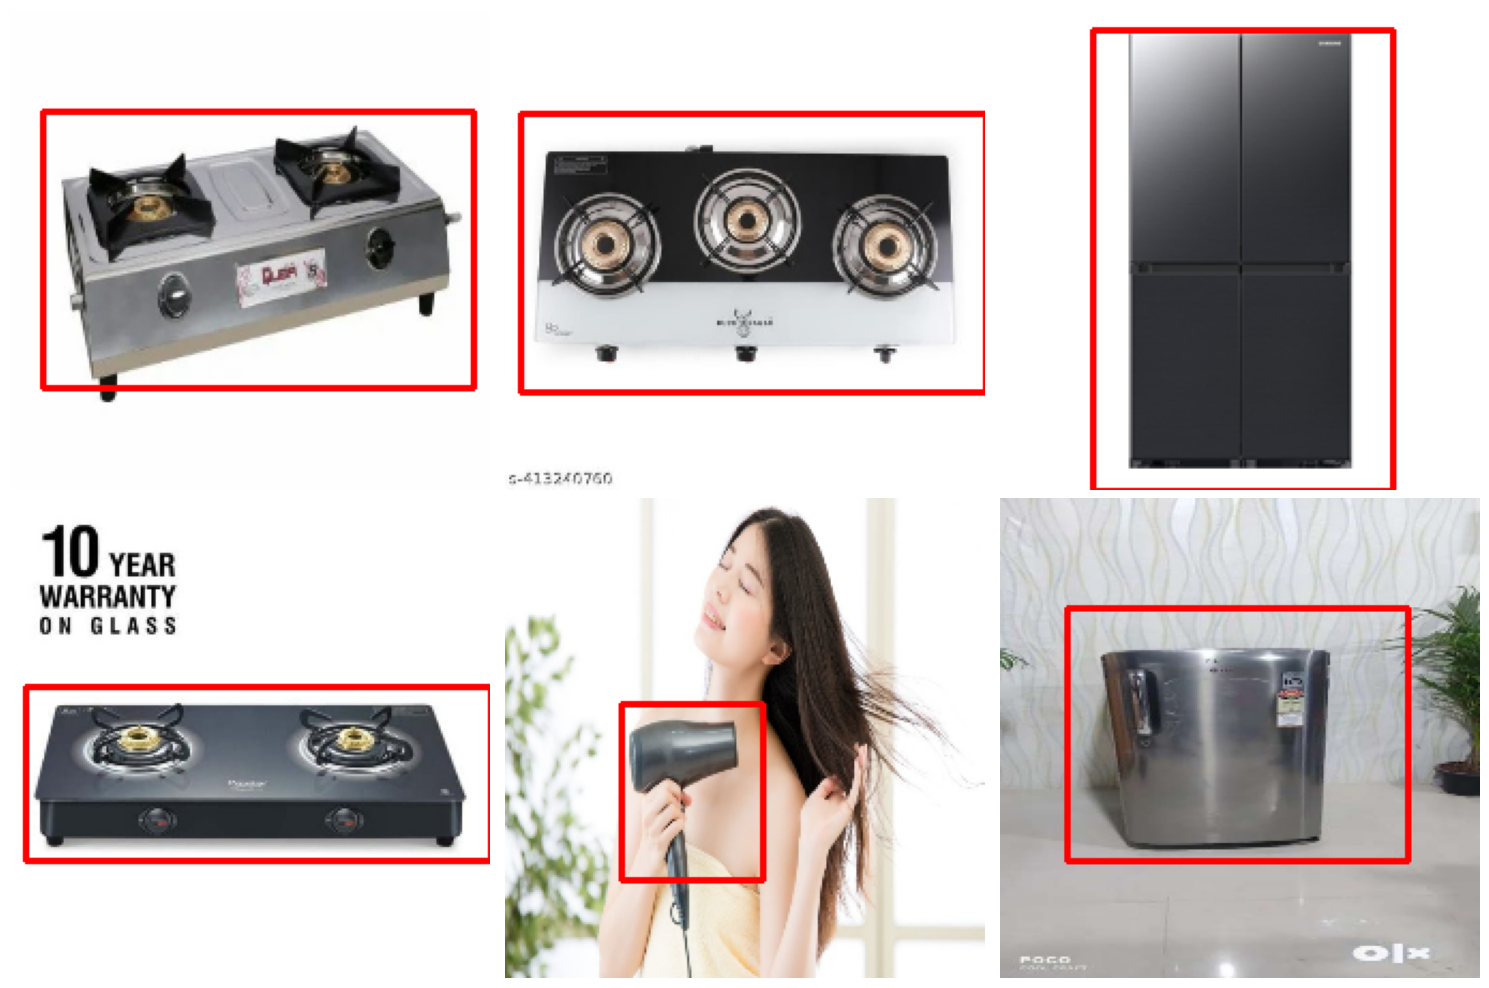

In [11]:
num_images = 6
selected_keys = list(data_dict.keys())

random_keys = np.random.choice(selected_keys, size=num_images, replace=False)

images = [visualize_bboxes(data_dict[key][0], data_dict[key][2]) for key in random_keys]

num_cols = 3
num_rows = math.ceil(num_images / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
axes = axes.ravel()

for ax, img in zip(axes, images):
    if img is not None:
        ax.imshow(img)
    ax.axis('off')

for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data Generator

In [12]:
train_size = int(len(data_dict) * 0.7)
val_size = int(len(data_dict) * 0.2)
test_size = len(data_dict) - train_size - val_size


train_img_list = list(data_dict.keys())[:train_size]
val_img_list = list(data_dict.keys())[train_size:train_size+val_size]
test_img_list = list(data_dict.keys())[train_size+val_size:]

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, data_ids, batch_size=32, img_size=(600, 600), n_classes=5, shuffle=True, **kwargs):
        super().__init__(**kwargs)

        self.file_list = [data[key][0] for key in data_ids]
        self.labels = [data[key][1] for key in data_ids]
        self.bbox_coords = [data[key][2] for key in data_ids]
        
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_list))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_file_list = [self.file_list[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]
        batch_bboxes = [self.bbox_coords[k] for k in batch_indexes]

        X, y_class, y_bbox = self.__data_generation(batch_file_list, batch_labels, batch_bboxes)

        return X, (y_class, y_bbox)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_file_list, batch_labels, batch_bboxes):
        X = np.empty((self.batch_size, *self.img_size, 3))
        y_class = np.empty((self.batch_size, self.n_classes), dtype=int)
        y_bbox = np.empty((self.batch_size, 4), dtype=float)

        for i, (img_path, label, bbox) in enumerate(zip(batch_file_list, batch_labels, batch_bboxes)):
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0

            X[i,] = img

            y_class[i] = tf.keras.utils.to_categorical(label, num_classes=self.n_classes)
            
            img_height, img_width, _ = img.shape
            bbox = batch_bboxes[i]
            
            y_bbox[i] = [
                float(bbox[0]) / img_width,   # x_min
                float(bbox[1]) / img_height,  # y_min
                float(bbox[2]) / img_width,   # x_max
                float(bbox[3]) / img_height   # y_max
            ]

        X = tf.convert_to_tensor(X)
        y_class = tf.convert_to_tensor(y_class)
        y_bbox = tf.convert_to_tensor(y_bbox)

        return X, y_class, y_bbox

In [14]:
train_generator = DataGenerator(data_dict, train_img_list, batch_size=16, img_size=(image_size, image_size), n_classes=5)
val_generator = DataGenerator(data_dict, val_img_list, batch_size=16, img_size=(image_size, image_size), n_classes=5)
test_generator = DataGenerator(data_dict, test_img_list, batch_size=16, img_size=(image_size, image_size), n_classes=5, shuffle=False)

## Model Architecture

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)

dense_1 = Dense(256, activation="relu", name='dense')(x)

# Classification branch
classify_1 = Dense(256, activation="relu", name="classify_1")(dense_1)
classify_output = Dense(5, activation="softmax", name='classifier')(classify_1)

# Bounding box regression branch
bbox_1 = Dense(256, activation="relu", name="bbox_1")(dense_1)
bbox_output = Dense(4, activation="linear", name='localizer')(bbox_1)

# Model definition
model = Model(inputs=base_model.input, outputs=[classify_output, bbox_output], name='multitask_model')

# Model compilation
model.compile(
    optimizer='adam',
    loss={'classifier': 'categorical_crossentropy', 'localizer': 'mse'},
    loss_weights={'classifier': 1.0, 'localizer': 2.0},
    metrics={'classifier': ['accuracy'], 'localizer': ['mse']}
)

In [16]:
model.summary()

Model: "multitask_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 21,271,369 (81.14 MB)

 Trainable params: 6,556,681 (25.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

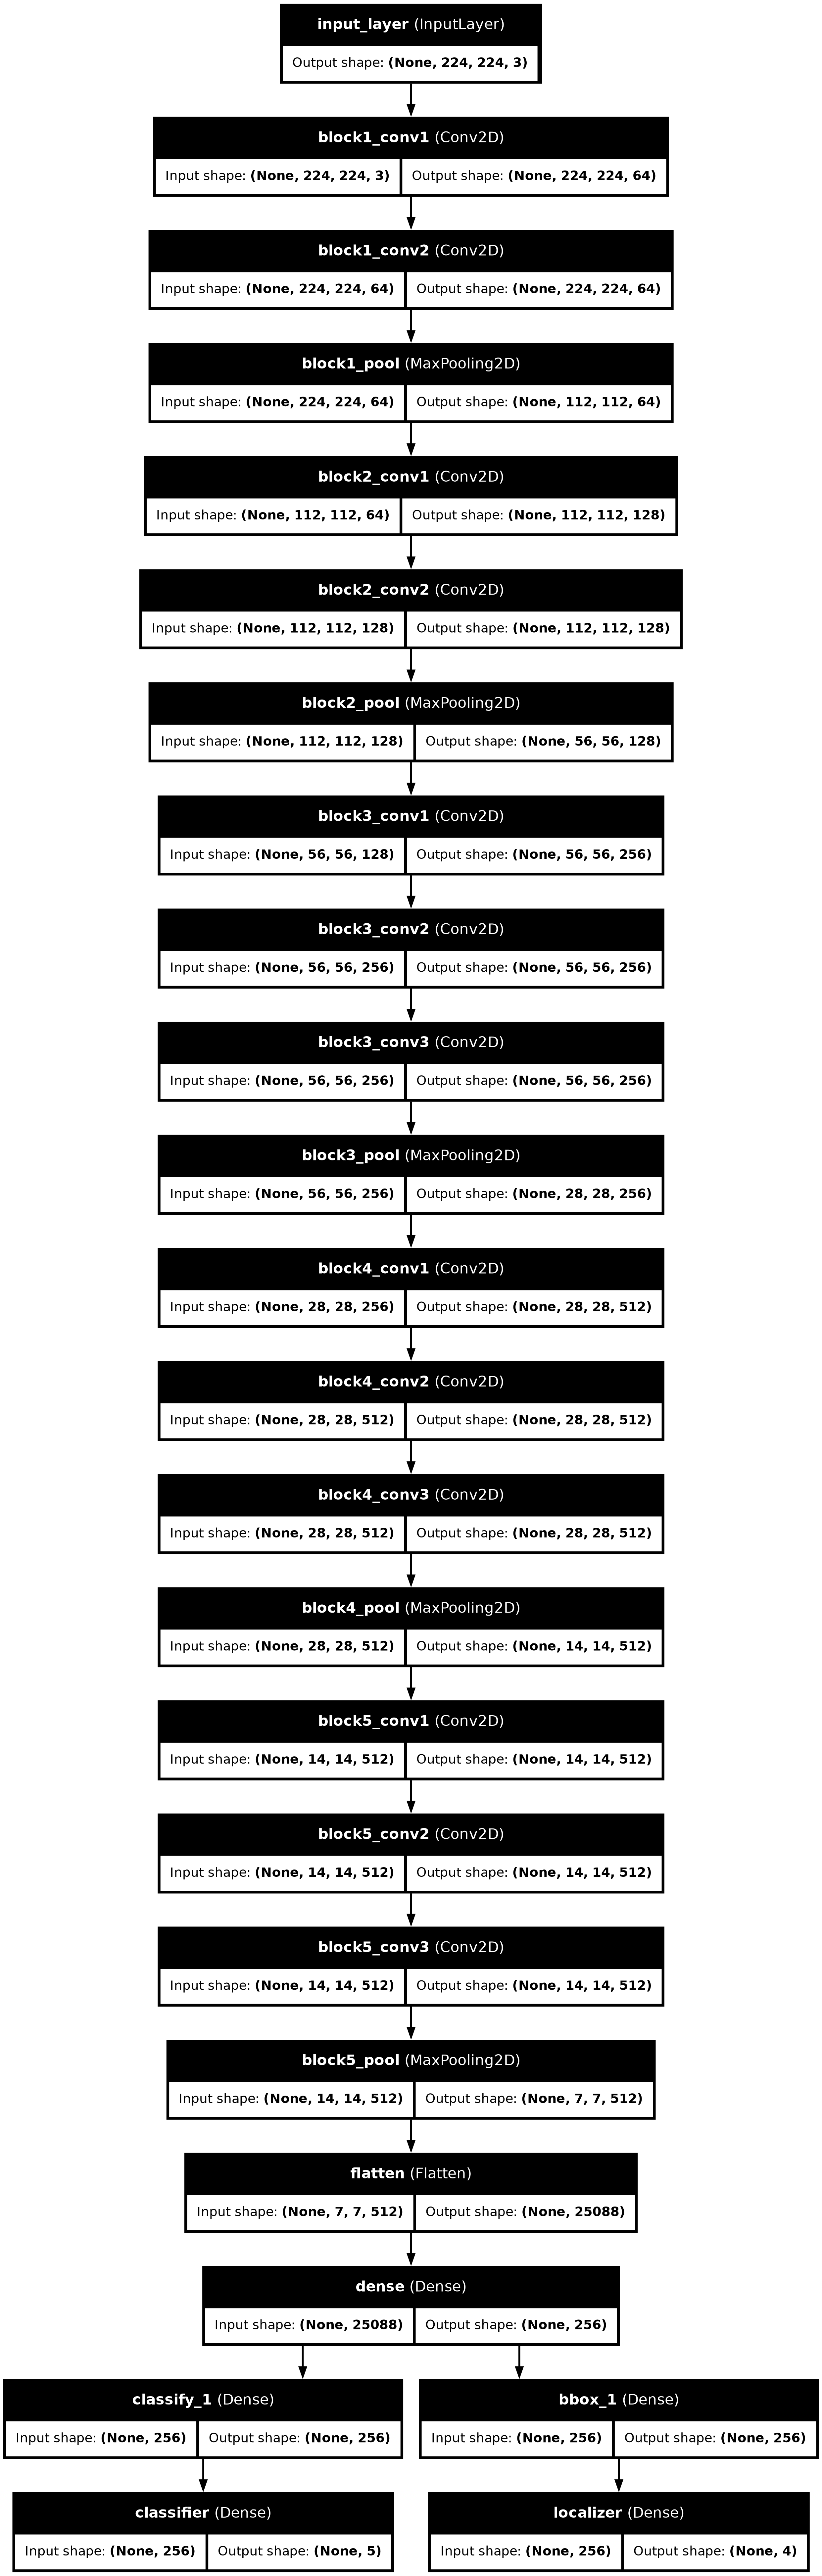

In [17]:
plot_model(model, show_layer_names=True, show_shapes=True)

## Training Model

In [18]:
tf.get_logger().setLevel('ERROR')

early_stopping = EarlyStopping(patience=5, monitor="val_classifier_accuracy", mode='max', restore_best_weights=True)

In [19]:
history = model.fit(train_generator,
                   epochs=20,
                   validation_data = val_generator,
                   callbacks = early_stopping)

Epoch 1/20
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - classifier_accuracy: 0.2031 - localizer_mse: 8.0935 - loss: 18.2503 

I0000 00:00:1724218051.381298    4067 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724218051.404491    4067 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - classifier_accuracy: 0.6271 - localizer_mse: 1.6404 - loss: 4.3318

W0000 00:00:1724218060.606406    4068 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - classifier_accuracy: 0.6288 - localizer_mse: 1.6290 - loss: 4.3042 - val_classifier_accuracy: 0.8906 - val_localizer_mse: 0.0445 - val_loss: 0.3849
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - classifier_accuracy: 0.9702 - localizer_mse: 0.0539 - loss: 0.2068 - val_classifier_accuracy: 0.9353 - val_localizer_mse: 0.0370 - val_loss: 0.2590
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - classifier_accuracy: 0.9991 - localizer_mse: 0.0206 - loss: 0.0545 - val_classifier_accuracy: 0.9308 - val_localizer_mse: 0.0233 - val_loss: 0.2588
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - classifier_accuracy: 0.9980 - localizer_mse: 0.0095 - loss: 0.0369 - val_classifier_accuracy: 0.9263 - val_localizer_mse: 0.0194 - val_loss: 0.2696
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - classifier_accuracy: 0.9997 - localizer_mse: 0.0077 - loss: 0.0215 - val_classifier_accuracy: 0.9353 - val_localizer_mse: 0.0189 - val

## *Plotting*

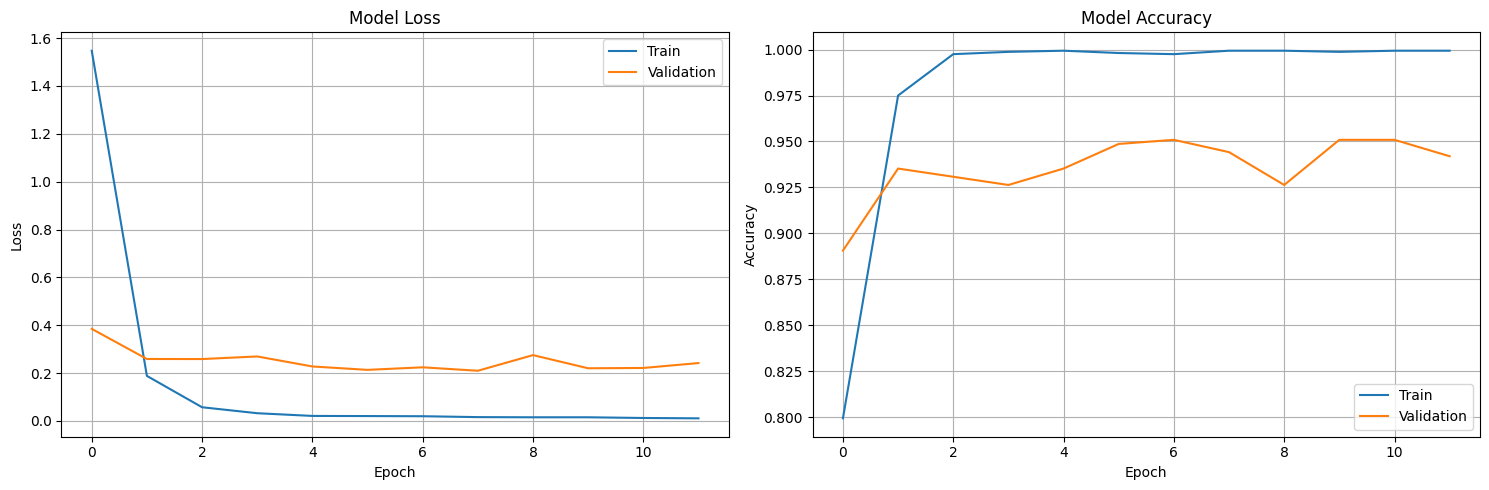

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(['Train', 'Validation'])
ax1.grid(True)

# Accuracy plot
ax2.plot(history.history['classifier_accuracy'])
ax2.plot(history.history['val_classifier_accuracy'])
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train', 'Validation'])
ax2.grid(True)

plt.tight_layout()
plt.show()

## *Save Model*

In [21]:
model.save("localizer.keras")

## *Load model*

In [22]:
model = load_model("localizer.keras")

## *Predictions*

In [23]:
yhat = model.evaluate(test_generator)

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - classifier_accuracy: 1.0000 - localizer_mse: 0.0197 - loss: 0.0624

W0000 00:00:1724218184.634332    4070 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - classifier_accuracy: 0.9680 - localizer_mse: 0.0177 - loss: 0.1039


In [24]:
def preprocess_image(img):
    img = img / 255.0
    img = cv2.resize(img, (image_size, image_size))
    img = np.expand_dims(img, axis=0)
    
    return img

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = preprocess_image(img)
    class_pred, bbox_pred = model.predict(img)
    class_name = class_names[np.argmax(class_pred)]
    _, width, height, _ = img.shape
    bbox_pred = bbox_pred[0]
    img = img[0]
    x1, y1, x2, y2 = int(bbox_pred[0] * width), int(bbox_pred[1] * height), int(bbox_pred[2] * width), int(bbox_pred[3] * height)
    
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    plt.imshow(img)
    
    plt.text(20, 20, class_name, color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


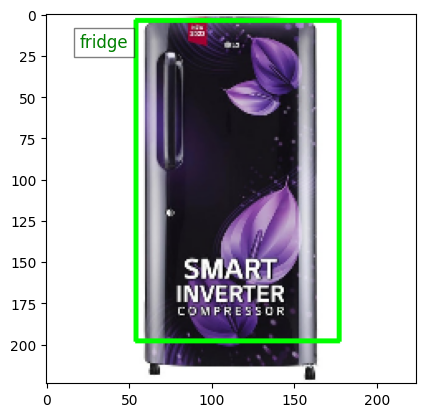

In [25]:
test_img = data_dict[test_img_list[0]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


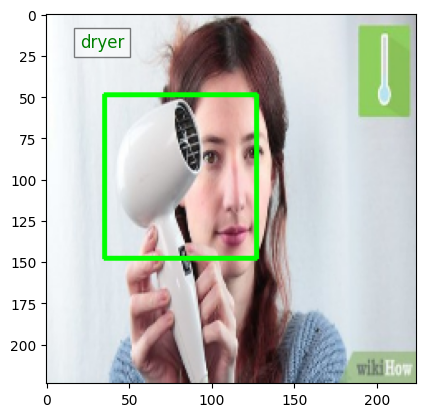

In [26]:
test_img = data_dict[test_img_list[15]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


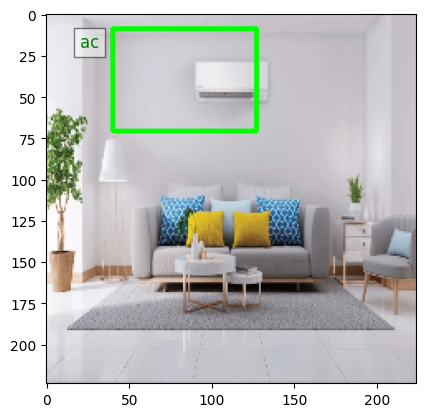

In [27]:
test_img = data_dict[test_img_list[30]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


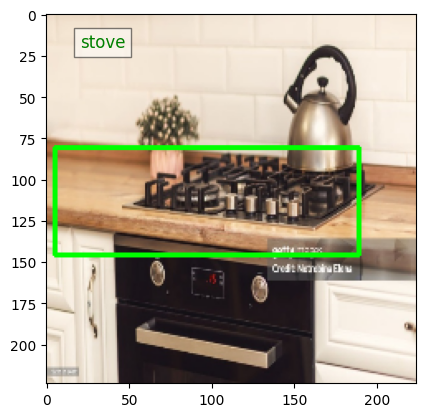

In [28]:
test_img = data_dict[test_img_list[80]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


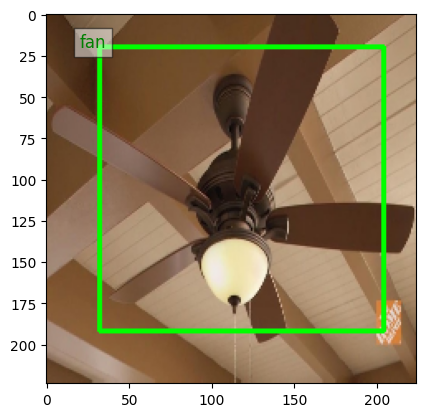

In [29]:
test_img = data_dict[test_img_list[100]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


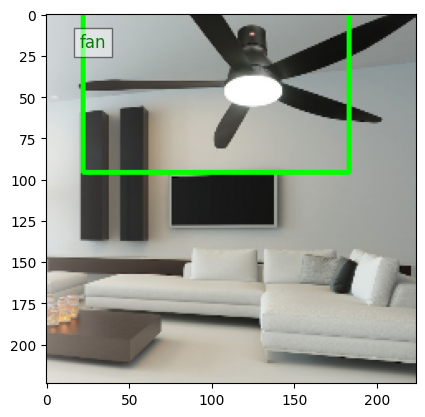

In [30]:
test_img = data_dict[test_img_list[150]][0]
predict_image(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


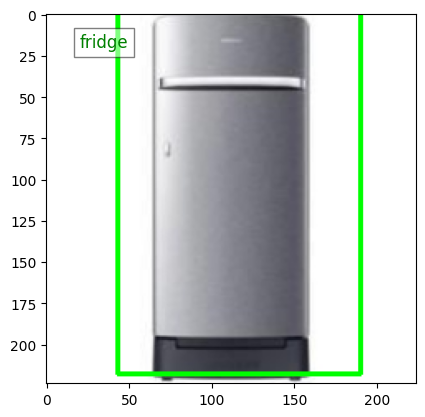

In [31]:
test_img = data_dict[test_img_list[200]][0]
predict_image(test_img)